In [57]:
from IPython.display import display, Markdown, HTML, Image
from nbtemplate import codetoggle, display_header

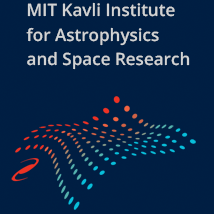

### Revision status
file: GratingInsertion.ipynb not found in repository (path missing or new file not yet commited?).
        No versioning information can be displayed.

This document is git version controlled. The repository is available at https://github.com/Chandra-MARX/grating-insertion.
See git commit log for full revision history.

Code was last run with:

MARXS ray-trace code version 1.3.dev44 (commit hash: 05872a3) (Date of dirty version: 20210913)


In [60]:
display_header('GratingInsertion.ipynb')

In [25]:
display(codetoggle)

# Ray-tracing incompete Chandra grating insertion

*I present ray-traces of Chandra grarings that are not fully inserted. The simulations concentrate on the effect of the insertion angle and do not treat other effects that also reduce the resolving power in Chandra grating spectroscopy (such as uncertainties in aspect blur or the finite spatial resolution of the detectors). Taking this into account, a grating insertion error of order 0.5 degrees will noticably broaden the LSF; larger dispersion angles (longer wavelength and higher orders) suffer more from the error.*

All the 3D views below are interactive if you view this on a website. They can be rotated, panned, and zoomed with the different mouse in all supported browsers; for trackpad users hold down CTRL or ALT for pan and zoom. Pressing "r" on the keyboard when the mouse is on a view returns that particular view to the initial position. See [the X3DOM documentation](https://www.x3dom.org/documentation/interaction/) for a full list of supported mouse and keyboard commands.

In [1]:
from mayavi import mlab
mlab.init_notebook('x3d', 800, 500)

Notebook initialized with x3d backend.


In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
# Set better defaults for log plots with a small (< 2 mag) range
mpl.rcParams['axes.formatter.min_exponent'] = 2
%matplotlib inline


In [3]:
import os

import warnings
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from marxs import simulator
from marxs.visualization.mayavi import plot_object, plot_rays
import transforms3d

In [4]:
from marxs.missions import chandra
aperture = chandra.Aperture()

In [5]:
coords = SkyCoord(30 * u.deg, 30 * u.deg)

In [6]:
from marxs.optics.marx import MarxMirror
from astropy.utils.data import get_pkg_data_filename
marxhrma = MarxMirror(parfile=get_pkg_data_filename('hrma.par',
                                                    package='marxs.optics'),
                      position=np.array([0, 0, 0]))

In [7]:
acis = chandra.ACIS(chips=[4,5,6,7,8,9], aimpoint=chandra.AIMPOINTS['ACIS-S'])

In [83]:
from marxs.design.tolerancing import oneormoreelements
import transforms3d

yoke_dir = {'HETG': (0, + np.sin(30 * u.deg), + np.cos(30 * u.deg)),
            'LETG': (0, + np.sin(30 * u.deg), - np.cos(30 * u.deg))}

@oneormoreelements
def rotate_around_yoke(e, angle, grating):
    '''Move and rotate origin of the whole `marxs.simulator.Parallel` object.


    '''
    e.uncertainty = transforms3d.affines.compose(np.zeros(3),
                                                 transforms3d.axangles.axangle2mat(yoke_dir[grating], angle),
                                                 np.ones(3))
    e.generate_elements()

## Simulation setup

We usually use the [marx](https://space.mit.edu/cxc/marx/) code to ray-trace gratinga on Chandra. Unfortunately, the internal structure of the code requires significant changes to rotate the grating support structure in the way we are discussing here. Thus, the simulations shown below use the marx mirror model, but simulate gratings and detectors with the [MARXS code](https://marxs.readthedocs.io/en/latest/), a Python ray-trace code I have written for the simulation of Arcus, Lynx, and a other missions. MARXS is explicitly designed to study misalignments of parts and, in fact, I have used it before to study the requirements on the repeatability of the grating insertion for Lynx in a setup very similar to what I present here.

That said, MARXS does not have the same fidelity for Chandra that marx has. In particular, it does not treat the characteristics of the detectors such as ACIS event grades or the HRC contributions to the point-speard functions. While it could simulate the Lissajous pattern of the Chandra pointing, MARXS does not (yet) write all the required keywords to run the event files it produces through CIAO for aspect reconstruction. So, at this point, the simulations below do not include all effects that influence the resolving power of the gratings in a real Chandra observation. However, they *do* describe how the LSF changes when the gratings are not fully inserted, which is what we want to study here. That is not an unreasonable approach: By ignoring the additional blurring of the LSF that stems from uncertainties in the aspect solution, the finite time resolution of the asol files and the ACIS readout (which contributed about 0.1" blurring for the standard 3.2 s ACIS read-out time), and the detector characteristics (event grade, HRC non-linearities in scale), we can isolate the effects that stem from changes in the grating position.

To further simplify the analysis, the simulations use an ideal, curved detector that follows the Rowland circle exactly, while HRC-S and ACIS-S are made up of several flat parts. This way, we do not have to worry aobut one of the simulated wavelengths hitting a chip gap. In that sense, all the numbers presented below for resolving power, effective area etc. are upper limits.

At this time, I am still missing some crucial input data for the LETG: I do not have a table of the exact locations of the facets. Therefore, the LETG simulations are performed by assuming the HEG and MEG facet locations, but with the LEG period and rotation angle. This impact the total effective area, but not the relative change of effective area with the grating insertion angle and will have a negligible effect on the resolving power, which is the main concern here.

Also, the location of the grating hinges is not fully correct, it's estimated from an unscaled drawing. I expect this to be good to about 5 mm; good enough that it will not change the results presented here.

## HETG

First, I am looking at the HETG. The reason for that is simply that the HETG is more fleshed out in MARXS. I do not expect any of the main conclusions to change from the additional simplifications made for the LETG simulations below, but it still seems sensible to do the most detailed analysis on the instrument where I have the most detailed input information.

### Geometry

In [10]:
# To simpliyfy the analysis for this paritcular problem, I add a circular detector.
# This detector is bend to follow the Rowland circle exactly and sufficiently large to catch all photons, 
# so the following analysis, I do not have to worry about chip gaps or the tiny deviations that ACIS-S or the 
# HRC-I have from the Rowland circle.
from marxs.optics import CircularDetector
from marxs.simulator import Propagator

rot = transforms3d.axangles.axangle2mat(np.array([0, 0, 1]), np.pi)
circdet = CircularDetector(orientation=rot,
                           zoom=[8632.48 / 2,
                                 8632.48 / 2,
                                 200],
                            position=[8632.48 / 2, 0, 0],
                          phi_lim=[-.3, .3])
# Rowland circle LETG ,8637.0
circdet.display['opacity'] = 0.2
circdet.detpix_name = ['circpix_x', 'circpix_y']
circdet.loc_coos_name = ['circ_phi', 'circ_y'] 

In [8]:
hetg = chandra.HETG()

In [11]:
chan = chandra.Chandra(elements=[marxhrma, hetg, 
                                 circdet, Propagator(distance=-100),
                                 acis])

In [12]:
# For 3D plotting
from marxs.simulator import KeepCol
keeppos = KeepCol('pos')
chan.postprocess_steps.append(keeppos)

In [122]:
from marxs.source import PointSource, FixedPointing

src = PointSource(coords=coords, energy=1 * u.keV)
# pointing shoudl be part of Chandra, but Chandra uses a Lissajois pattern
# Here, I simplify and thus I keep is as a separate object to avoid confusion
pnt = FixedPointing(coords=coords)


In [14]:
photons = src.generate_photons(1000 * u.s)
photons = pnt(photons)

In [15]:
photons = chan(photons)

In [17]:
hetg2 = chandra.HETG()
rotate_around_yoke(hetg2, np.deg2rad(10), 'HETG')

In [18]:
fig = mlab.figure()

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
out = plot_object(chan, viewer=fig)
out = plot_object(hetg2, viewer=fig)
#out = plot_object(circdet, viewer=fig)
pos = keeppos.format_positions()
ind = (photons['facet'] >= 0)
out = plot_rays(pos[ind, :, :], scalar=photons['order'][ind], viewer=fig)
fig

Monoenergetic (1 keV) simulation of the HETG in nominal position. Active grating area is shown in white. Additionally, the HETG is shown rotated by 10 deg. In practice, the positioning will be much better than that, but this large rotation makes it easy to see in which directions the gratings are displaced to check the setup of the geometry. The curved yellow surface marks the location of a large, ideal detector following the Rowland circle. Zooming in on the focal plane, the 6 chips of ACIS-S are also visible.

### Line profiles

I first show how the line profiles change for a few examples. This is a simulation with 1 keV photons. The plots below show the photon distribution in order -1 for the MEG and HEG. Note that the x and y axes are scaled differently. At this energy, the HEG data is not typically captured in a standard setup, but it can serve as an example of line shapes at larger distances from the focal point.

In [131]:
photons = src.generate_photons(1e5 * u.s)
photons = pnt(photons)
photons = marxhrma(photons)

In [132]:
hetg = chandra.HETG()

p = hetg(photons.copy())
p = circdet(p)
p = Propagator(distance=-100)(p)
p = acis(p)

In [133]:
rotate_around_yoke(hetg, np.deg2rad(.5), 'HETG')

p2 = hetg(photons.copy())
p2 = circdet(p2)
p2 = Propagator(distance=-100)(p2)
p2 = acis(p2)

In [134]:
rotang = {'LEG': 0 * u.deg, 'HEG': 5 * u.deg, 'MEG': -5 * u.deg}

In [135]:
# de-rotate
def derotate(photons, angle, d_rowland):
    x = d_rowland * photons['circ_phi']
    y = photons['circ_y']
    return x * np.cos(angle) + y * np.sin(angle), x * np.sin(angle) - y * np.cos(angle)

In [136]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_order(p1, p2, grating, d_rowland, percentiles=[1, 99], legendtext=['__no_label__', '__no_label__']):
    x, y = derotate(p1, rotang[grating], d_rowland / 2)
    x1, y1 = derotate(p2, rotang[grating], d_rowland / 2)

    fig, ax = plt.subplots(figsize=(5.5, 5.5))

    ax.scatter(x, y)
    ax.scatter(x1, y1, marker='+')
    ax.set_xlim(*np.percentile(x1, percentiles))
    ax.set_ylim(*np.percentile(y1, percentiles))

    # Set aspect of the main axes.
    #ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    # make some labels invisible
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)

    xbins=np.linspace(*np.percentile(x1, percentiles), 100)
    ybins=np.linspace(*np.percentile(y1, percentiles), 100)

    ax_histx.hist(x, bins=xbins, density=True)
    ax_histy.hist(y, bins=ybins, density=True, orientation='horizontal')
    ax_histx.hist(x1, bins=xbins, density=True, histtype='step')
    ax_histy.hist(y1, bins=ybins, density=True, histtype='step', orientation='horizontal')
    
    ax.set_ylabel('cross-dispersion [mm]')
    ax.set_xlabel('dispersion coordinate [mm]')
    
    return fig, ax

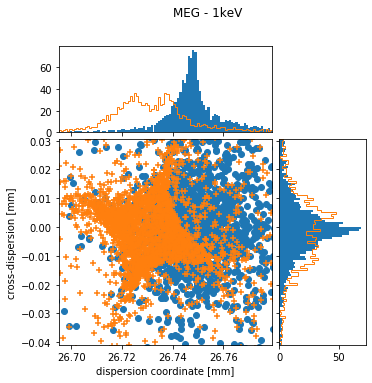

In [137]:
ind = (p['order'] == -1) & (p['mirror_shell'] <= 1)
ind1 = (p2['order'] == -1) & (p2['mirror_shell'] <= 1)

fig, ax = plot_order(p[ind], p2[ind1], 'MEG', 8632.48, [3, 97], ['nominal position', '1 deg rotation'])

out = fig.suptitle('MEG - 1keV')

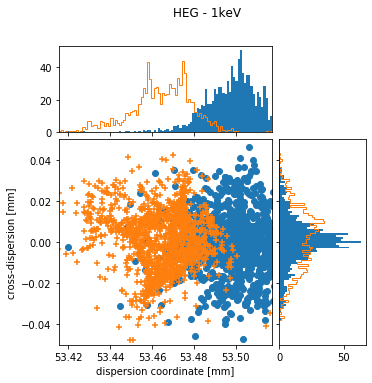

In [142]:
ind = (p['order'] == -1) & (p['mirror_shell'] > 1)  # Note that mirror shells are counted from the outside
ind1 = (p2['order'] == -1) & (p2['mirror_shell'] > 1)

fig, ax = plot_order(p[ind], p2[ind1], 'HEG', 8632.48, [1, 99.8], ['nominal position', '1 deg rotation'])

# Some hand-tweaking of plot limits
ax.set_ylim(-0.05, 0.05)

out = fig.suptitle('HEG - 1keV')

In both plots, the blue points and histograms are for the nominal position of the HETG, the orange symbols and histograms are for a grating insertion error of 0.5 deg. Shapes in the HEG and MEG are similar, but more extreme in the HEG because of the larger dispersion angle. If the grating is not fully inserted, the center of the distribution is at smaller dispersion coordinates and the shape approaches the outside of a square. This shape can be understood as follows: The Rowland torus is designed in such a way that rays have the best possible focus in dispersion direction at the detectors. Even for a misaligned grating, that is still true for some gratings since the gratings located closest to the yoke move only very little. On the other hand, the gratings furthest from the yoke move significantly more and thus photons coming from those gratings will be significnalty out of focus. Because the yoke is angled with respect to the dispersion direction, the resulting shape is not symetric to the dispersion either. 

In the following sections, I simply use the standard deviation $\sigma$ as a measure of how wide each line is and estimate the resolving power as $R = \sigma/\Delta x$, where $\Delta x$ is the distance between the zero order and the mean location of the photons of this wavelength. A very detailed analysis using the predicted more complex line profiles as LSF when fitting spectra might be able to recover more information, but for the present purposes, it is sufficient to simply take the standard deviation as a measure of the width of the LSF.

In [32]:
from marxs.design.tolerancing import CaptureResAeff
from marxs.analysis.gratings import (resolvingpower_from_photonlist,
                                 effectivearea_from_photonlist)

class CaptureResAeffPos(CaptureResAeff):
    def __call__(self, photons):
        '''Calculate Aeff and R for an input photon list.

        Parameters
        ----------
        photons : `astropy.table.Table`
            Photon list.

        Returns
        -------
        result : dict
            Dictionary with per-order Aeff, R, and position of order center.
        '''
        aeff = effectivearea_from_photonlist(photons, self.orders, len(photons),
                                             self.A_geom, self.order_col)
        try:
            ind = (np.isfinite(photons[self.dispersion_coord]) &
                   (photons['probability'] > 0))
            res, pos, std = resolvingpower_from_photonlist(photons[ind], self.orders,
                                                           col=self.dispersion_coord,
                                                           zeropos=None,
                                                           ordercol=self.order_col)
        except AnalysisError:
            # Something did not work, e.g. too few photons to find zeroth order
            res = np.nan * np.ones(len(self.orders))

        return {'Aeff': aeff, 'R': res, 'pos': pos}

  

orderanalyzer = CaptureResAeffPos(orders=np.arange(-3, 4), dispersion_coord='tg_mm')

In [33]:
def analyseHEG(photons, orderanalyzer):
    out = {}
    for grat in ['MEG', 'HEG']:
        if grat == 'MEG':
            p = photons[photons['mirror_shell'] > 1]
        elif grat == 'HEG':
            p = photons[photons['mirror_shell'] < 2]
        x, y = derotate(p, rotang[grat], 8632.48)
        p['tg_mm'] = x
        p['tg_d'] = y
        for k, v in orderanalyzer(p).items():
            out[grat + '_' + k] = v
    return out

In [34]:
from marxs.design.tolerancing import run_tolerances_for_energies2
from marxs.simulator import Sequence
from functools import partial

tab = run_tolerances_for_energies2(src, 
                                   [0.5, 1., 2.] * u.keV,
                                   #[.5, 1., 2., 4., 8.] * u.keV,
                                   Sequence(elements=[pnt, marxhrma, hetg, circdet]),
                                   type(hetg),
                                   partial(rotate_around_yoke, grating='HETG'), 
                                   # for plotting on log plots, it's good to have a point that is close to 0, but
                                   # still a positive number
                                   parameters=[{'angle': np.deg2rad(a)} for a in [0, 0.01, 0.1, 0.2, 0.3, 0.5, 1., 1.5, 2., 3., 5.]],
                                   analyzefunc=partial(analyseHEG, orderanalyzer=orderanalyzer),
                                   reset={'angle': 0},
                                   t_source = 1e5 * u.s)

Working on simulation 0/11


/Users/hamogu/code/marxs/marxs/optics/grating.py:248: RuntimeWarning: invalid value encountered in arccos
  n)))


Working on simulation 1/11
Working on simulation 2/11
Working on simulation 3/11
Working on simulation 4/11
Working on simulation 5/11
Working on simulation 6/11
Working on simulation 7/11
Working on simulation 8/11
Working on simulation 9/11
Working on simulation 10/11
Working on simulation 0/11
Working on simulation 1/11
Working on simulation 2/11
Working on simulation 3/11
Working on simulation 4/11
Working on simulation 5/11
Working on simulation 6/11
Working on simulation 7/11
Working on simulation 8/11
Working on simulation 9/11
Working on simulation 10/11
Working on simulation 0/11
Working on simulation 1/11
Working on simulation 2/11
Working on simulation 3/11
Working on simulation 4/11
Working on simulation 5/11
Working on simulation 6/11
Working on simulation 7/11
Working on simulation 8/11
Working on simulation 9/11
Working on simulation 10/11


### Resolving power

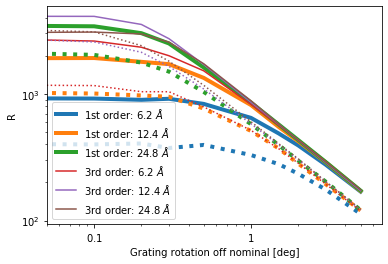

In [64]:
from cycler import cycler
custom_cycle = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color']) * \
               cycler(linestyle=['-', ':'])

fig, axes = plt.subplots()
axes.set_prop_cycle(custom_cycle)
t_wave = tab.group_by('wave')

q = 'R'
for key, g in zip(t_wave.groups.keys, t_wave.groups):
    axes.loglog(np.rad2deg(g['angle']), np.mean(g[f'MEG_{q}'].data[:, [2,4]], axis=1), 
                label='1st order: {:3.1f} $\AA$'.format(key[0]), lw=4)
    axes.semilogx(np.rad2deg(g['angle']), np.mean(g[f'HEG_{q}'].data[:, [2,4]], axis=1), lw=4)

for key, g in zip(t_wave.groups.keys, t_wave.groups):
    axes.loglog(np.rad2deg(g['angle']), np.mean(g[f'MEG_{q}'].data[:, [0, 6]], axis=1), 
                label='3rd order: {:3.1f} $\AA$'.format(key[0]))
    axes.semilogx(np.rad2deg(g['angle']), np.mean(g[f'HEG_{q}'].data[:, [0, 6]], axis=1))

                  
axes.set_xlabel('Grating rotation off nominal [deg]')
axes.set_ylabel(q)
axes.set_xlim(0.05, None)
out = axes.legend()

Resolving power for HEG (solid lines) and MEG (dotted) with insertion angle error. In the nominal position (angle=0 deg), the resolving power for a given order depends linearly on the wavelength, simply because photons of longer wavelength are diffracted to larger angles. The same holds to photons of different orders: $R$ increases with order.  
Note that in practice Chandra does not reach the highest resolving powers shown in the figure above for several reasons. Long wavelengths and higher orders may not actually fall on the ACIS array. For example, the highest $R$ values shown are for third order photons with $\lambda > 12$ Ang, which do not fall on the ACIS chips. Similarly, the efficiency for longer wavelength in the HEG is so low that no usuable signal is collected in practice. 
Furthermore, the simulations here ignore a number of other effects that reduce the resolving power, e.g. uncertainties in the aspect solution, the difference between flat gratings and the ideal curved Rowland circle, or the finite pixel size of the detectors. The goal here is to see when the rotation of the HESS becomes the *dominant* effect on $R$. While I do not include all those other effect in the simulations here, we can assume that they roughly add up in quadrature; whatever the details of this, the final $R$ will always be lower than the number shown here due to these effects. *Because of this, the values for R shown in the figure above are higher than what the real Chandra provides.*

**The resolving power starts dropping noticably aroud 0.3 deg and falls dramatically above 1 deg or so. Longer wavelength and higher orders start to suffer earlier.** It is interesting to see that for larger errors in angle $R$ does no longer depend on wavelength or diffraction order because the line broadening introduced by the error in grating position grows with the diffraction angle.

In the plot above, positive and negative orders are averaged. However, for a rotated HESS, positive and negative orders are no longer symmetric. One set of spectra is now under the "high" side of the HESS and the other one is located under the "low" side. This causes small differences in the line profile, which can be seen in the simulations.

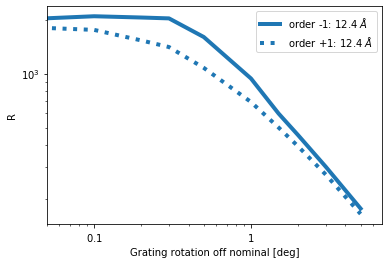

In [65]:
fig, axes = plt.subplots()
axes.set_prop_cycle(custom_cycle)
t_wave = tab.group_by('wave')

q = 'R'

g = t_wave.groups[1]
key = t_wave.groups.keys[1]
axes.loglog(np.rad2deg(g['angle']), g[f'MEG_{q}'].data[:, 2], 
                label='order -1: {:3.1f} $\AA$'.format(key[0]), lw=4)
axes.loglog(np.rad2deg(g['angle']), g[f'MEG_{q}'].data[:, 4], 
                label='order +1: {:3.1f} $\AA$'.format(key[0]), lw=4)
    
axes.set_xlabel('Grating rotation off nominal [deg]')
axes.set_ylabel(q)
axes.set_xlim(0.05, None)
out = axes.legend()

For no rotation, the resolving power $R$ is (up to the noise in the Monte-Carlo simulation) identical in the positive and negative orders of the MEG. With increasing rotation, one side performs better than the other one, until the roation becomes very large.

### Wavelength solution

When the HESS is the not in the correct position, the gratings will be on average futher from the mirror and closer to the focal plane. That means that the light rays go through the mirrors later and, even if diffracted by the same angle, don't make it as far away from the zero order. One can think of this as a smaller average Rowland circle. This effect can be calculated analytically, but the simulations show it, too.

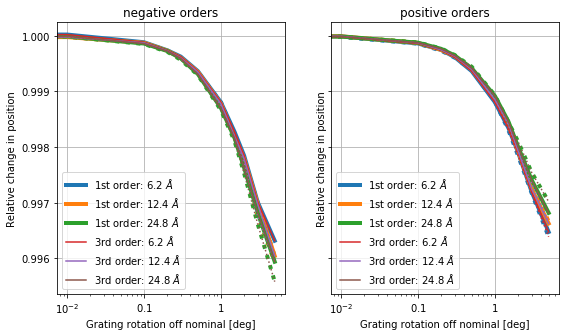

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 5), sharey=True)


q = 'pos'

for ax, imeg, iheg in zip(axes, [2, 4], [0, 6]):
    ax.set_prop_cycle(custom_cycle)
    for key, g in zip(t_wave.groups.keys, t_wave.groups):
        ax.semilogx(np.rad2deg(g['angle']), 
                g[f'MEG_{q}'].data[:, imeg] / g[f'MEG_{q}'].data[0, imeg], 
                label='1st order: {:3.1f} $\AA$'.format(key[0]), lw=4)
        ax.semilogx(np.rad2deg(g['angle']), 
                g[f'HEG_{q}'].data[:, iheg] / g[f'HEG_{q}'].data[0, iheg], lw=4)

    for key, g in zip(t_wave.groups.keys, t_wave.groups):
        ax.semilogx(np.rad2deg(g['angle']), 
                g[f'MEG_{q}'].data[:, imeg] / g[f'MEG_{q}'].data[0, imeg],
                label='3rd order: {:3.1f} $\AA$'.format(key[0]))
        ax.semilogx(np.rad2deg(g['angle']), 
                  g[f'HEG_{q}'].data[:, iheg] / g[f'HEG_{q}'].data[0, iheg])

    ax.set_xlabel('Grating rotation off nominal [deg]')             
    
    ax.set_ylabel('Relative change in position')
    out = ax.legend()
    ax.grid(True)

axes[0].set_title('negative orders')
out = axes[1].set_title('positive orders')

There are slight differences between the positive and negative orders, because the geometry is not symmetric when tilted, as the HESS now has a high side and a low side. In both cases, the differences are of order 0.1% at 1 deg or about 300 km/s. 

So, unless the insertion error is significantly below one degree, this is in the range we need to worry about, in particular, because this is systematic. Since the gratings will never be rotated too far, but always too low, every Chandra observation would indicate smaller diffraction angles (i.e. shorter wavelength).


In some observations, the wavelength solutions can be obtained from the observation itself (self-calibration). Today, this is only done for calibration observations (Capella), but in principle this can be done for any observation with features at a known position, or for any observation where the same feature is observed in both first and third order (I'm not writing down the full math here, but seeing the same feature in two orders gives us an extra piece of information, which we can use to solve for the angle of rotation of the HESS). However, in the vast majority of observations, we will need to rely on a known wavelength solution. 

### Loss of photons / Changes in effective area

Currently the code does not have information how the grating efficiency changes with infall angle. The HETG [ground calibration report](https://space.mit.edu/HETG/papers/final.020228.pdf) (figures 4.11 and 4.12) indicates that these changes are large, but linear at about 7%/deg for the MEG and 35%/deg for the HEG. We expect this effect to almost exactly cancel out due to the way the HESS is populated with gratings. Gratings are manufactured for a specific sector and are thus marked as A, B, ..., but there is no difference in the grating mounts between gratings mounted in sectors A and AA, or B and BB etc. Since gratings in opposing sectors A and AA are rotatated by 180 deg with respect to each other, we expect that any loss in effective area in sector A is exactly compensated by a gain in AA for any particular order.

What is easy to check in ray-tracing is if a photons actually hits a grating membrane or if it hits a frame instead. I call this the geometric area of the gratings and this is shown in the next plot.

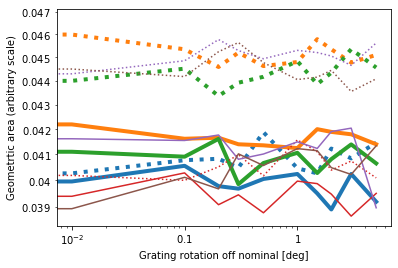

In [38]:
fig, axes = plt.subplots()
axes.set_prop_cycle(custom_cycle)
t_wave = tab.group_by('wave')

q = 'Aeff'
for key, g in zip(t_wave.groups.keys, t_wave.groups):
    axes.loglog(np.rad2deg(g['angle']), np.mean(g[f'MEG_{q}'].data[:, [2,4]], axis=1), 
                label='1st order: {:3.1f} $\AA$'.format(key[0]), lw=4)
    axes.semilogx(np.rad2deg(g['angle']), np.mean(g[f'HEG_{q}'].data[:, [2,4]], axis=1), lw=4)

for key, g in zip(t_wave.groups.keys, t_wave.groups):
    axes.loglog(np.rad2deg(g['angle']), np.mean(g[f'MEG_{q}'].data[:, [0, 6]], axis=1), 
                label='3rd order: {:3.1f} $\AA$'.format(key[0]))
    axes.semilogx(np.rad2deg(g['angle']), np.mean(g[f'HEG_{q}'].data[:, [0, 6]], axis=1))

                  
axes.set_xlabel('Grating rotation off nominal [deg]')
out = axes.set_ylabel('Geometrtic area (arbitrary scale)')

Shown is the geometric area of the grating. Note that the y axis has an arbitrary scale, only the change of area with angle is significant. (I could normalize all curves to 1 at angle=0 deg, but then they would be hard to see because they are all plotted on top of each other.) Colors and line styles are identical to the figure "R vs. angle" above.

The change in geometric area shown here differs from the *effective area* as is does not take into account any change in diffraction efficiency for photons that do not arrive perpendicular to the grating surface. Instead, this is a simple geometric area (on an arbitrary scale). This area is constant within the noise of the Monte-Carlo simulation. That means that we are not yet loosing photons because they hit the frames instead of the active surface. For angles as small as we discuss here that is the expected result since the gratings only move by a few mm; much less that their physical size. Still, it is good as a cross-check for the validity fo the simulation.

## LETG

Results for the LETG should be very similar to the HETG results, except that the LETG usually uses the HRC-S which reaches to larger diffraction angles. Thus, I show only a subset of the figures I presented for the HETG. Nevertheless, I think that the simulations I present here are sufficient to answer the core question "How much tolorance on the exact insertion angle can we tolerate?"

See the section on the HETG above for a detailed description of the figures.

In [84]:
# LETG not yet implemented in MARXS so we mock it up starting from HETG
# most parameters are similar and small differences don't matter much for this study
from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table
from marxs.optics import FlatGrating, OrderSelector
from marxs.math.rotations import ex2vec_fix
from transforms3d.affines import compose
from marxs.simulator import Parallel

class LETG(Parallel):

    id_col = 'facet'

    def __init__(self, **kwargs):
        self.hess = Table.read(get_pkg_data_filename('HESSdesign.rdb', package='marxs.missions.chandra'))
        '''The HESS datafile is commented very well inside the rdb file.

        Here, I just need to make a note about the relation of the
        coordinate systems: The vectors that define the facet edges
        are called x and y in the rdb file.  In the MARXS global
        coordinate system these are y and z respectively, so uxf -> y
        and uyg -> z.

        Datafile from: http://space.mit.edu/HETG/hess/basic.html

        '''
        kwargs['elem_pos'] = self.calculate_elempos()
        kwargs['elem_class'] = FlatGrating
        # Gratings are defined in order MEG, then HEG
        d = 0.000991216
        kwargs['elem_args'] = {'order_selector': OrderSelector(np.arange(-3, 4)),
                               'd': d, 'name': list(self.hess['hessloc'])}
        super().__init__(**kwargs)

        # I would like to put the center of the HETG on its hinge point.
        # Unfortunately, I don't know that hinge point very well, so I'm guessing a little.
        move = np.eye(4)
        move[:, 3] = [8618., -650 * np.sin(np.deg2rad(-60)),
                      650 * np.cos(np.deg2rad(-60)), 1.]
        self.move_center(move)

    def calculate_elempos(self):
        '''Read position of facets from file.

        Based on the positions, other grating parameters are chosen
        that differ between HEG and MEG, e.g. grating constant.

        '''
        # take x,y,z components of various vectors and put in numpy
        # arrays Note: This makes (3, N) arrays as opposed to (N, 3)
        # arrays used in other parts of MARXS.  Note: Sometimes an
        # angle has a minus. Beware of active / passive rotations.
        hess = self.hess

        cen = np.vstack([hess[s+'c'].data for s in 'xyz'])
        cen[0, :] += (339.909 - 1.7) * 25.4

        # All those vectors are already normalized
        facnorm = np.vstack([hess[s + 'u'].data for s in 'xyz'])

        pos4ds = []
        for i in range(facnorm.shape[1]):
            # Take HEG facets. Should really be round, but I wait until I 
            # have the real dimensions until I do that.
            zoom = np.array([1, 0.920*25.4/2, 0.920*25.4/2])
            rot = ex2vec_fix(facnorm[:, i], [0, 1, 0])
            pos4d = compose(cen[:, i], rot, zoom)
            pos4ds.append(pos4d)
        return pos4ds


In [85]:
letg = LETG()

In [86]:
chan = chandra.Chandra(elements=[marxhrma, letg, 
                                 circdet, Propagator(distance=-100),
                                 acis])

In [87]:
# For 3D plotting
keeppos = KeepCol('pos')
chan.postprocess_steps.append(keeppos)

In [88]:
photons = src.generate_photons(1000 * u.s)
photons = pnt(photons)

In [89]:
photons = chan(photons)

In [90]:
letg2 = LETG()
rotate_around_yoke(letg2, np.deg2rad(30), 'LETG')

In [91]:
fig = mlab.figure()

out = plot_object(chan, viewer=fig)
out = plot_object(letg2, viewer=fig)
pos = keeppos.format_positions()
ind = (photons['facet'] >= 0)
out = plot_rays(pos[ind, :, :], scalar=photons['order'][ind], viewer=fig)
fig

In [92]:
def analyseLEG(photons, orderanalyzer):
    photons['tg_mm'] = photons['circ_phi'] * 8632.48 / 2  # d_Rowland for HEG, because we use HEG positions
    photons['tg_d'] = photons['circ_y']
    return orderanalyzer(photons)

In [93]:
tabl = run_tolerances_for_energies2(src, 
                                   [0.1, 1., 5.] * u.keV,
                                   #[.5, 1., 2., 4., 8.] * u.keV,
                                   Sequence(elements=[pnt, marxhrma, letg, circdet]),
                                   type(letg),
                                   partial(rotate_around_yoke, grating='LETG'), 
                                   # for plotting on log plots, it's good to have a point that is close to 0, but
                                   # still a positive number
                                   parameters=[{'angle': np.deg2rad(a)} for a in [0, 0.01, 0.1, 0.2, 0.3, 0.5, 1., 1.5, 2., 3., 5.]],
                                   analyzefunc=partial(analyseLEG, orderanalyzer=orderanalyzer),
                                   reset={'angle': 0},
                                   t_source = 1e5 * u.s)

Working on simulation 0/11
Working on simulation 1/11
Working on simulation 2/11
Working on simulation 3/11
Working on simulation 4/11
Working on simulation 5/11
Working on simulation 6/11
Working on simulation 7/11
Working on simulation 8/11
Working on simulation 9/11
Working on simulation 10/11
Working on simulation 0/11
Working on simulation 1/11
Working on simulation 2/11
Working on simulation 3/11
Working on simulation 4/11
Working on simulation 5/11
Working on simulation 6/11
Working on simulation 7/11
Working on simulation 8/11
Working on simulation 9/11
Working on simulation 10/11
Working on simulation 0/11
Working on simulation 1/11
Working on simulation 2/11
Working on simulation 3/11
Working on simulation 4/11
Working on simulation 5/11
Working on simulation 6/11
Working on simulation 7/11
Working on simulation 8/11
Working on simulation 9/11
Working on simulation 10/11


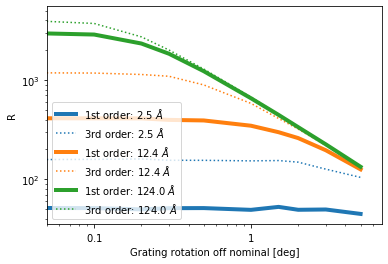

In [94]:
fig, axes = plt.subplots()
t_wave = tabl.group_by('wave')
axes.set_prop_cycle(custom_cycle)
q = 'R'
for key, g in zip(t_wave.groups.keys, t_wave.groups):
    axes.loglog(np.rad2deg(g['angle']), np.mean(g[q].data[:, [2,4]], axis=1), 
                label='1st order: {:3.1f} $\AA$'.format(key[0]), lw=4)

    axes.loglog(np.rad2deg(g['angle']), np.mean(g[q].data[:, [0, 6]], axis=1), 
                label='3rd order: {:3.1f} $\AA$'.format(key[0]))

                  
axes.set_xlabel('Grating rotation off nominal [deg]')
axes.set_ylabel(q)
axes.set_xlim(0.05, None)
out = axes.legend()

Similar to the HETG, the LETG resolving power increases with wavelength and this order. Like the HETG, the LETG does not reach the theoratical maximum because of other limitations (uncertainty in aspect solution etc.). Taking this into account, an insertion error below 0.5 deg or so is probably tolerable for the LSF, above that value $R$ will decrease for long wavelength.

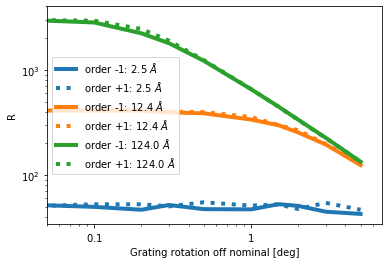

In [95]:
fig, axes = plt.subplots()
axes.set_prop_cycle(custom_cycle)
t_wave = tabl.group_by('wave')

q = 'R'

g = t_wave.groups[1]
key = t_wave.groups.keys[1]
for key, g in zip(t_wave.groups.keys, t_wave.groups):
    axes.loglog(np.rad2deg(g['angle']), g[q].data[:, 2], 
                label='order -1: {:3.1f} $\AA$'.format(key[0]), lw=4)
    axes.loglog(np.rad2deg(g['angle']), g[q].data[:, 4], 
                label='order +1: {:3.1f} $\AA$'.format(key[0]), lw=4)
    
axes.set_xlabel('Grating rotation off nominal [deg]')
axes.set_ylabel(q)
axes.set_xlim(0.05, None)
out = axes.legend()

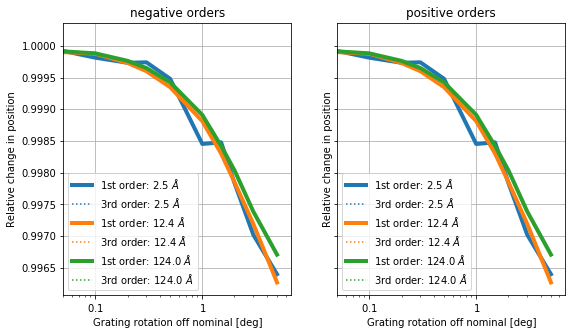

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 5), sharey=True)


q = 'pos'

for ax, ileg, iheg in zip(axes, [2, 4], [0, 6]):
    ax.set_prop_cycle(custom_cycle)
    for key, g in zip(t_wave.groups.keys, t_wave.groups):
        ax.semilogx(np.rad2deg(g['angle']), 
                g[q].data[:, imeg] / g[q].data[0, imeg], 
                label='1st order: {:3.1f} $\AA$'.format(key[0]), lw=4)

        ax.semilogx(np.rad2deg(g['angle']), 
                g[q].data[:, imeg] / g[q].data[0, imeg],
                label='3rd order: {:3.1f} $\AA$'.format(key[0]))


    ax.set_xlabel('Grating rotation off nominal [deg]')             
    
    ax.set_ylabel('Relative change in position')
    out = ax.legend()
    ax.grid(True)
    ax.set_xlim(0.05, None)

axes[0].set_title('negative orders')

out = axes[1].set_title('positive orders')